In [1]:
import sqlite3
import csv
import math
import pandas as pd

# Create a connection to a new in-memory SQLite database
conn = sqlite3.connect(':memory:')
cur = conn.cursor()

# Create tables
cur.execute('''
    CREATE TABLE person (
        person_id INTEGER PRIMARY KEY AUTOINCREMENT,
        age REAL,
        gender TEXT,
        education TEXT,
        income REAL,
        employment_experience INTEGER,
        home_ownership TEXT
    )
''')

cur.execute('''
    CREATE TABLE loan (
        person_id INTEGER,
        amount REAL,
        intent TEXT,
        interest_rate REAL,
        percent_income REAL,
        credit_history_length REAL,
        credit_score INTEGER,
        previous_defaults TEXT,
        status INTEGER,
        FOREIGN KEY(person_id) REFERENCES person(person_id)
    )
''')



# Load data from CSV file and insert into tables
csv_file_path = r"C:/Users/Admin/Downloads/neha/loan_data.csv"
with open(csv_file_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    person_id = 1  # Start assigning IDs from 1
    for row in reader:
        cur.execute('''
            INSERT INTO person (person_id, age, gender, education, income, employment_experience, home_ownership)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (person_id, row['person_age'], row['person_gender'], row['person_education'],
              row['person_income'], row['person_emp_exp'], row['person_home_ownership']))

        cur.execute('''
            INSERT INTO loan (person_id, amount, intent, interest_rate, percent_income,
                              credit_history_length, credit_score, previous_defaults, status)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (person_id, row['loan_amnt'], row['loan_intent'], row['loan_int_rate'],
              row['loan_percent_income'], row['cb_person_cred_hist_length'], row['credit_score'],
              row['previous_loan_defaults_on_file'], row['loan_status']))

        person_id += 1  # Increment ID for each new person

conn.commit()


# SQL query to join the `person` and `loan` tables to reconstruct the data
query = '''
    SELECT 
        p.person_id,
        p.age AS person_age,
        p.gender AS person_gender,
        p.education AS person_education,
        p.income AS person_income,
        p.employment_experience AS person_emp_exp,
        p.home_ownership AS person_home_ownership,
        l.amount AS loan_amnt,
        l.intent AS loan_intent,
        l.interest_rate AS loan_int_rate,
        l.percent_income AS loan_percent_income,
        l.credit_history_length AS cb_person_cred_hist_length,
        l.credit_score AS credit_score,
        l.previous_defaults AS previous_loan_defaults_on_file,
        l.status AS loan_status
    FROM 
        person p
    JOIN 
        loan l
    ON 
        p.person_id = l.person_id
'''

# Execute the query and load the data into a Pandas DataFrame
df = pd.read_sql_query(query, conn)


In [2]:
df.columns # All the column names are understandable, so they don't need renaming 

Index(['person_id', 'person_age', 'person_gender', 'person_education',
       'person_income', 'person_emp_exp', 'person_home_ownership', 'loan_amnt',
       'loan_intent', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'credit_score',
       'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')

In [3]:
df.head()

,person_id,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,1,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,2,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,3,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,4,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,5,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [4]:
missing_values=df.isnull().sum()
print(missing_values) #There are no missing values

person_id                         0
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


In [5]:
# Checking for duplicate entries based on 'person_id'
duplicate_rows = df[df.duplicated('person_id', keep=False)]

# Optionally, you can drop duplicates if that's necessary for your analysis
# df = df.drop_duplicates('person_id', keep='first')

print("Duplicate Rows based on person_id:\n", duplicate_rows)

Duplicate Rows based on person_id:
 Empty DataFrame
Columns: [person_id, person_age, person_gender, person_education, person_income, person_emp_exp, person_home_ownership, loan_amnt, loan_intent, loan_int_rate, loan_percent_income, cb_person_cred_hist_length, credit_score, previous_loan_defaults_on_file, loan_status]
Index: []


#### There are no dupliates ^^^^^^

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame containing the 'person_income' column
Q1 = df['person_income'].quantile(0.25)
Q3 = df['person_income'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying outliers
outliers = df[(df['person_income'] < lower_bound) | (df['person_income'] > upper_bound)]

# Printing outliers
print("Outliers in the dataset:")
print(outliers)

Outliers in the dataset:
       person_id  person_age person_gender person_education  person_income  \
15            16        23.0        female           Master       600891.0   
20            21        25.0          male         Bachelor       195718.0   
33            34        25.0        female      High School       368115.0   
34            35        26.0        female        Associate       361076.0   
42            43        26.0          male         Bachelor       361293.0   
...          ...         ...           ...              ...            ...   
44831      44832        25.0        female      High School       192090.0   
44836      44837        26.0          male        Doctorate       293525.0   
44922      44923        29.0          male           Master       726416.0   
44947      44948        42.0          male        Doctorate       705960.0   
44972      44973        43.0          male        Associate       184295.0   

       person_emp_exp person_home_owne

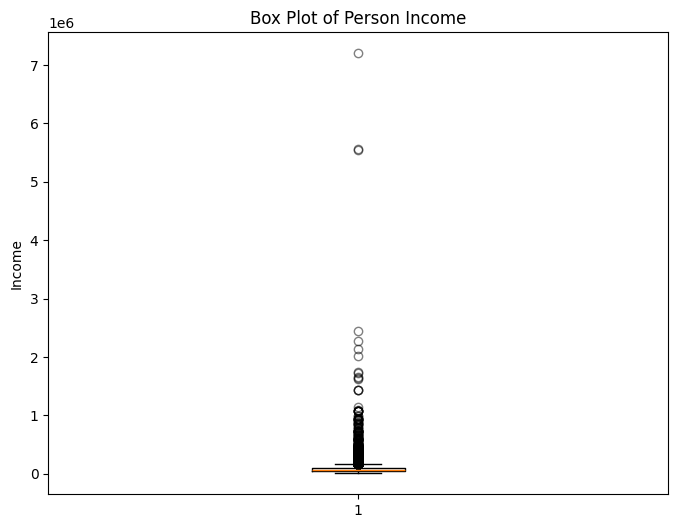

In [7]:
# Plotting a boxplot to visualize outliers
plt.figure(figsize=(8, 6))
plt.boxplot(df['person_income'], vert=True, flierprops=dict(marker='o', color='red', alpha=0.5))
plt.title('Box Plot of Person Income')
plt.ylabel('Income')
plt.show()

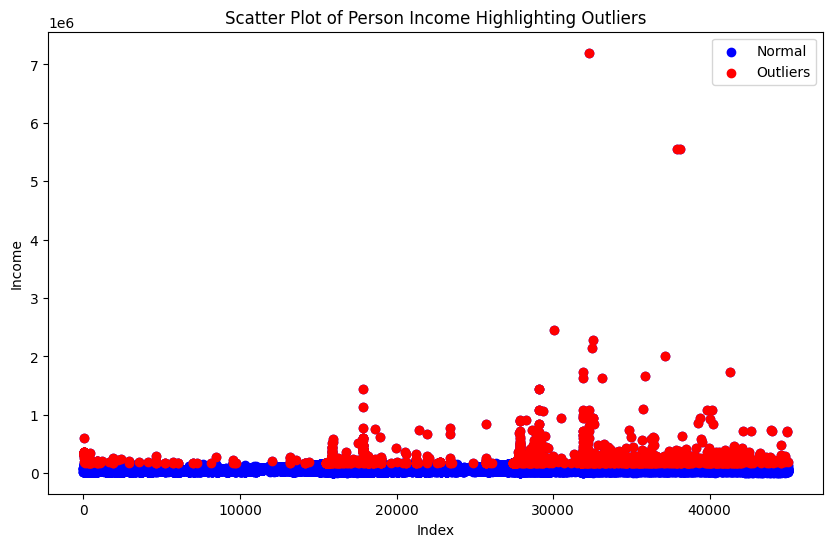

In [8]:
# Plotting all data points
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['person_income'], color='blue', label='Normal')

# Overlaying outliers in a different color
plt.scatter(outliers.index, outliers['person_income'], color='red', label='Outliers')

plt.title('Scatter Plot of Person Income Highlighting Outliers')
plt.xlabel('Index')
plt.ylabel('Income')
plt.legend()
plt.show()

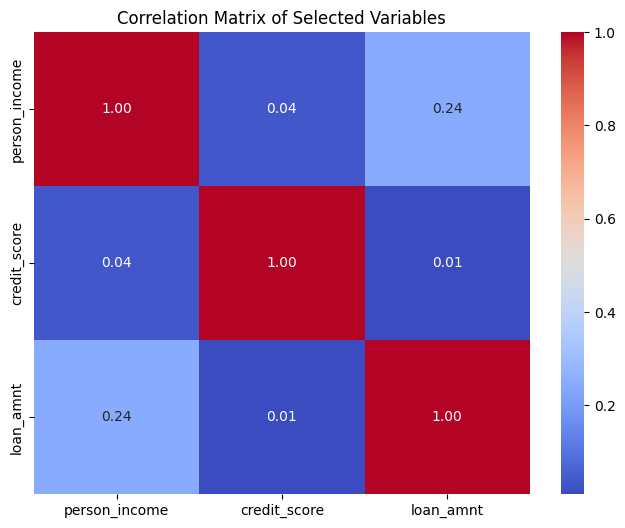

In [9]:
import seaborn as sns

# Selecting a few columns to check correlation
sub_df = df[['person_income', 'credit_score', 'loan_amnt']]

# Calculating correlation matrix
corr_matrix = sub_df.corr()

# Plotting the heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Selected Variables')
plt.show()

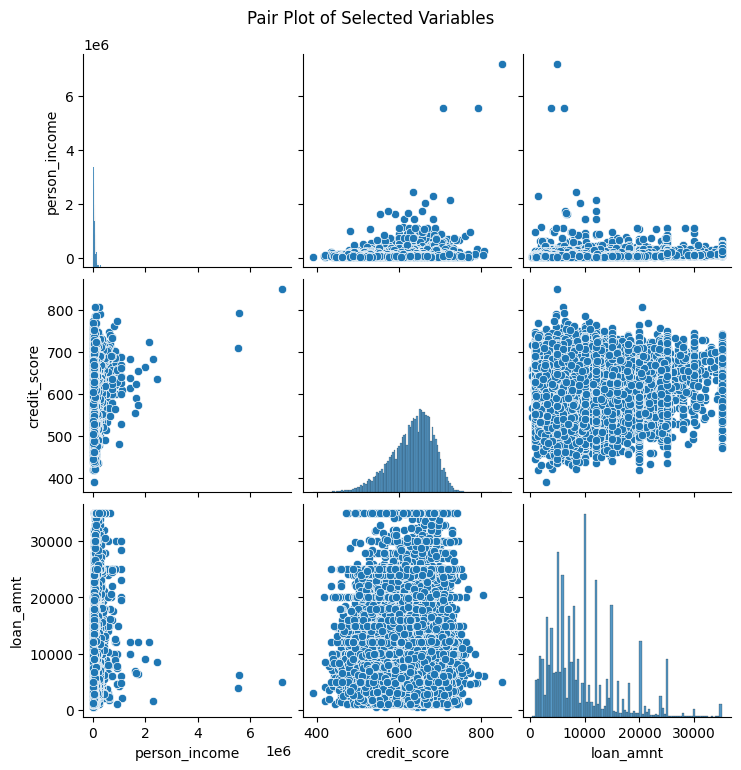

In [10]:
# Plotting pair plots for the same subset of data
sns.pairplot(sub_df)
plt.suptitle('Pair Plot of Selected Variables', y=1.02)  # Adjust the title position
plt.show()

### The dataset is skewed ^^^^ Dataset should be normalized 

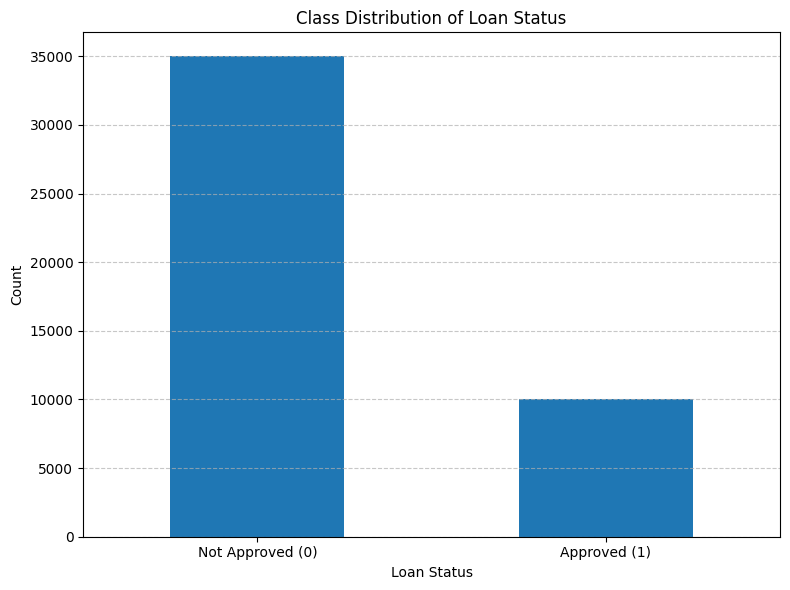

In [11]:
import matplotlib.pyplot as plt

# Check for class imbalance in the target variable `loan_status`
class_counts = df['loan_status'].value_counts()

# Plot the class imbalance
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks([0, 1], labels=['Not Approved (0)', 'Approved (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [12]:
#Stratification
from sklearn.model_selection import train_test_split
# Determine if stratification is needed
# Since 'Exited' is the target variable and it is imbalanced, stratify based on 'Exited'
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Step 5: Perform train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train/Test Split Completed:\n")
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train/Test Split Completed:

Train size: 36000
Test size: 9000


In [13]:
# pip install ydata-profiling


In [14]:
import pandas as pd

# Load your dataset (replace this with your actual data loading method)
# Example: df = pd.read_csv("your_dataset.csv")

# List of categorical columns to one-hot encode
categorical_columns = ['person_gender', 'person_education', 'person_home_ownership', 
                       'loan_intent', 'previous_loan_defaults_on_file']

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Save the encoded DataFrame to ensure it's compatible with profiling tools
df_encoded.to_csv("loan_data_encoded.csv", index=False)

print("One-hot encoding completed. Encoded dataset saved as 'loan_data_encoded.csv'.")

One-hot encoding completed. Encoded dataset saved as 'loan_data_encoded.csv'.


In [15]:
# problematic_columns = [
#     'loan_status', 'person_gender_1', 'person_education_1', 'person_education_2', 
#     'person_education_3', 'person_education_4', 'person_home_ownership_1', 
#     'person_home_ownership_2', 'person_home_ownership_3', 'loan_intent_1', 
#     'loan_intent_2', 'loan_intent_3', 'loan_intent_4', 'loan_intent_5', 
#     'previous_loan_defaults_on_file_1'
# ]

# # Convert all problematic columns to float for compatibility
# df_encoded[problematic_columns] = df_encoded[problematic_columns].astype(float)


In [16]:
from ydata_profiling import ProfileReport

try:
    profile = ProfileReport(df_encoded, title="Fixed Dataset Profiling Report")
    profile.to_file("fixed_dataset_profile.html")
    print("Fixed profiling report saved as 'fixed_dataset_profile.html'")
except Exception as e:
    print(f"Profiling still failed with error: {e}")

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 73.86it/s]

Fixed profiling report saved as 'fixed_dataset_profile.html'


In [17]:
# df_cleaned = df_encoded.drop(columns=problematic_columns)

# try:
#     profile = ProfileReport(df_cleaned, title="Cleaned Dataset Profiling Report")
#     profile.to_file("cleaned_dataset_profile.html")
#     print("Cleaned profiling report saved as 'cleaned_dataset_profile.html'")
# except Exception as e:
#     print(f"Profiling failed even after dropping problematic columns: {e}")

In [18]:
import webbrowser
report_path = "cleaned_dataset_profile.html"  
webbrowser.open(report_path)


True

In [19]:
#pip install scikit-learn mlflow

EXPERIMENT 1

In [20]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Load dataset
df = pd.read_csv("C:\\Users\\Admin\\Downloads\\neha\\loan_data.csv")  

# Define feature and target columns
X = df.drop(columns=['loan_status'])  # Replace with your target column
y = df['loan_status']

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_standard', StandardScaler(), numeric_features),
        ('num_minmax', MinMaxScaler(), numeric_features),
        ('num_log', FunctionTransformer(np.log1p), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', logreg)])

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__solver': ['liblinear', 'lbfgs']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', verbose=2)
grid_search.fit(X_train, y_train)

# Cross-validation
kf_3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
kf_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1_scores_3 = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=kf_3, scoring='f1')
f1_scores_10 = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=kf_10, scoring='f1')

# Training data evaluation
y_pred_train = grid_search.best_estimator_.predict(X_train)
f1_train = f1_score(y_train, y_pred_train)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()

# MLFlow Logging
mlflow.set_tracking_uri("https://dagshub.com/nehamahesh02/projectt.mlflow")
import os
os.environ["MLFLOW_TRACKING_USERNAME"] = "nehamahesh02"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "bb54b19d319da30bf1cf99703cce8275e1d891cc"

mlflow.set_experiment("Logistic Regression Experiment")

with mlflow.start_run() as run:
    try:
        mlflow.log_param("Best Parameters", str(grid_search.best_params_))
        mlflow.log_metric("Mean F1 (3-Fold CV)", float(f1_scores_3.mean()))
        mlflow.log_metric("Std F1 (3-Fold CV)", float(f1_scores_3.std()))
        mlflow.log_metric("Mean F1 (10-Fold CV)", float(f1_scores_10.mean()))
        mlflow.log_metric("Std F1 (10-Fold CV)", float(f1_scores_10.std()))
        mlflow.log_metric("F1 (Training Data)", float(f1_train))
        mlflow.log_metric("True Positives", int(tp))
        mlflow.log_metric("True Negatives", int(tn))
        mlflow.log_metric("False Positives", int(fp))
        mlflow.log_metric("False Negatives", int(fn))
        mlflow.sklearn.log_model(grid_search.best_estimator_, "logistic_regression_pipeline")
        print(f"Run ID: {run.info.run_id}")
        print(f"MLFlow Run: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/{run.info.experiment_id}/runs/{run.info.run_id}")
    except Exception as e:
        print(f"Error logging to MLFlow: {e}")

# Final Output
print("Best Parameters:", grid_search.best_params_)
print("Mean F1 (3-Fold CV):", f1_scores_3.mean())
print("Std F1 (3-Fold CV):", f1_scores_3.std())
print("Mean F1 (10-Fold CV):", f1_scores_10.mean())
print("Std F1 (10-Fold CV):", f1_scores_10.std())
print("F1 Score (Training):", f1_train)
print("Confusion Matrix: TP =", tp, ", TN =", tn, ", FP =", fp, ", FN =", fn)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ....classifier__C=0.1, classifier__solver=liblinear; total time=   0.1s
[CV] END ....classifier__C=0.1, classifier__solver=liblinear; total time=   0.3s
[CV] END ....classifier__C=0.1, classifier__solver=liblinear; total time=   0.3s
[CV] END ........classifier__C=0.1, classifier__solver=lbfgs; total time=   0.4s
[CV] END ........classifier__C=0.1, classifier__solver=lbfgs; total time=   0.1s
[CV] END ........classifier__C=0.1, classifier__solver=lbfgs; total time=   0.2s
[CV] END ....classifier__C=1.0, classifier__solver=liblinear; total time=   0.2s
[CV] END ....classifier__C=1.0, classifier__solver=liblinear; total time=   0.3s
[CV] END ....classifier__C=1.0, classifier__solver=liblinear; total time=   0.6s
[CV] END ........classifier__C=1.0, classifier__solver=lbfgs; total time=   0.2s
[CV] END ........classifier__C=1.0, classifier__solver=lbfgs; total time=   0.2s
[CV] END ........classifier__C=1.0, classifier__s

2024/12/20 01:23:04 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Error logging to MLFlow: INVALID_PARAMETER_VALUE: Response: {'error_code': 'INVALID_PARAMETER_VALUE'}
🏃 View run tasteful-jay-280 at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/1/runs/dcecf5b4a17c4bcea5bf3c56d2b5419b
🧪 View experiment at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/1
Best Parameters: {'classifier__C': 10.0, 'classifier__solver': 'lbfgs'}
Mean F1 (3-Fold CV): 0.7754866915127515
Std F1 (3-Fold CV): 0.008265098914840993
Mean F1 (10-Fold CV): 0.7740752833965505
Std F1 (10-Fold CV): 0.009005189045210872
F1 Score (Training): 0.7745885954841178
Confusion Matrix: TP = 6072 , TN = 26394 , FP = 1606 , FN = 1928


EXPERIMENT 2

In [21]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, f1_score
import mlflow
import mlflow.sklearn

# Load your dataset
df = pd.read_csv("C:\\Users\\Admin\\Downloads\\neha\\loan_data.csv")  

# Define Target and Features
X = df.drop(columns=['loan_status'])  
y = df['loan_status']

# Preprocessing
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_standard', StandardScaler(), numeric_features),
        ('num_minmax', MinMaxScaler(), numeric_features),
        ('num_log', FunctionTransformer(np.log1p), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define pipeline with Logistic Regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Determine scoring based on target classes
if len(y.unique()) == 2:
    scoring = 'f1'  # Binary classification
else:
    scoring = 'f1_macro'  # Multi-class classification

# Initialize MLFlow
mlflow.set_tracking_uri("https://dagshub.com/nehamahesh02/projectt.mlflow")  
mlflow.set_experiment("Logistic Regression Experiment")

# Cross-validation (3 folds)
with mlflow.start_run():
    # Perform 3-fold cross-validation
    scores = cross_val_score(pipeline, X, y, cv=3, scoring=scoring)
    mean_f1 = scores.mean()
    std_f1 = scores.std()
    print(f"Mean F1-Score: {mean_f1:.4f}, Std: {std_f1:.4f}")
    
    # Log cross-validation metrics
    mlflow.log_metric("mean_f1_score", mean_f1)
    mlflow.log_metric("std_f1_score", std_f1)

    # Train pipeline on entire training set
    pipeline.fit(X, y)

    # Predictions and Confusion Matrix
    y_pred = pipeline.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    train_f1 = f1_score(y, y_pred)
    print(f"F1-Score on Training Data: {train_f1:.4f}")
    print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
    
    # Log training metrics and confusion matrix
    mlflow.log_metric("train_f1_score", train_f1)
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)

    # Log model to MLFlow
    mlflow.sklearn.log_model(pipeline, "logistic_regression_pipeline")

print("Pipeline and Metrics Logged Successfully")


Mean F1-Score: 0.7745, Std: 0.0173
F1-Score on Training Data: 0.7776
Confusion Matrix: TP=7631, TN=33004, FP=1996, FN=2369


2024/12/20 01:23:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bedecked-vole-287 at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/1/runs/48afdd6e09854ef89262bbd0f705a6b7
🧪 View experiment at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/1
Pipeline and Metrics Logged Successfully


In [22]:
import os
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
import mlflow
import mlflow.sklearn
from sklearn import set_config

# ------------------- Load Dataset -------------------
df = pd.read_csv("C:\\Users\\Admin\\Downloads\\neha\\loan_data.csv")  

# ------------------- Define Features and Target -------------------
X = df.drop(columns=['loan_status'])  
y = df['loan_status']  

# Split the data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ------------------- Preprocessing -------------------
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_standard', StandardScaler(), numeric_features),
        ('num_minmax', MinMaxScaler(), numeric_features),
        ('num_log', FunctionTransformer(np.log1p, validate=True), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# ------------------- Define LogisticRegression Pipeline -------------------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Enable pipeline visualization
set_config(display="diagram")  

# ------------------- MLFlow Integration -------------------
mlflow.set_tracking_uri("https://dagshub.com/nehamahesh02/projectt.mlflow")  
mlflow.set_experiment("Logistic Regression Pipeline")

os.environ["MLFLOW_TRACKING_USERNAME"] = "nehamahesh02"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "bb54b19d319da30bf1cf99703cce8275e1d891cc"

with mlflow.start_run():
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions and metrics
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Log Metrics
    mlflow.log_metric("f1_score_test", f1)
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)

    # Log Parameters
    mlflow.log_param("solver", "lbfgs")  # Default solver for LogisticRegression
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("random_state", 42)

    # Save pipeline diagram as an HTML file with UTF-8 encoding
    from sklearn.utils import estimator_html_repr
    pipeline_html = estimator_html_repr(pipeline)
    with open("logistic_pipeline.html", "w", encoding="utf-8") as f:  # Specify UTF-8 encoding
        f.write(pipeline_html)

    # Log pipeline diagram to MLFlow
    mlflow.log_artifact("logistic_pipeline.html", artifact_path="pipeline_diagram")

    # Print results
    print(f"F1-Score on Test Data: {f1:.4f}")
    print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
    print(f"MLFlow Run: {mlflow.active_run().info.run_id}")
    print(f"View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")

# ------------------- Render Interactive Pipeline Diagram -------------------
try:
    from IPython.display import display
    display(pipeline)  # Render diagram interactively in Jupyter Notebook
except ImportError:
    print("Error")


F1-Score on Test Data: 0.7904
Confusion Matrix: TP=1550, TN=6628, FP=372, FN=450
MLFlow Run: 0bfa5f8dfbf249a8b5221af14077e4d1
View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/4/runs/0bfa5f8dfbf249a8b5221af14077e4d1
🏃 View run traveling-finch-990 at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/4/runs/0bfa5f8dfbf249a8b5221af14077e4d1
🧪 View experiment at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/4


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_standard',
                                                  StandardScaler(),
                                                  Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'],
      dtype='object')),
                                                 ('num_minmax', MinMaxScaler(),
                                                  Index(['person_age', 'person_income', 'person_emp_exp', 'loan_...
                                                  Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['person_gender', 'person_education', 'person_home_ownership',
       'loan_intent', 'previous_loan_defaults_on_file'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix, f1_score
import mlflow
import mlflow.sklearn
from sklearn import set_config

# ------------------- Define Features and Target -------------------
X = df.drop(columns=['loan_status'])  
y = df['loan_status']  # Target

# Split the data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ------------------- Preprocessing -------------------
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_standard', StandardScaler(), numeric_features),
        ('num_minmax', MinMaxScaler(), numeric_features),
        ('num_log', FunctionTransformer(np.log1p, validate=True), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# ------------------- Define RidgeClassifier Pipeline -------------------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RidgeClassifier(random_state=42))
])

# Enable pipeline visualization
set_config(display="diagram")  

# ------------------- MLFlow Integration -------------------
mlflow.set_tracking_uri("https://dagshub.com/nehamahesh02/projectt.mlflow")  # DagsHub repository and username
mlflow.set_experiment("RidgeClassifier Pipeline")

os.environ["MLFLOW_TRACKING_USERNAME"] = "nehamahesh02"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "bb54b19d319da30bf1cf99703cce8275e1d891cc"

with mlflow.start_run():
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions and metrics
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Log Metrics
    mlflow.log_metric("f1_score_test", f1)
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)

    # Log Parameters
    mlflow.log_param("alpha", 1.0)  # Default alpha value for RidgeClassifier
    mlflow.log_param("random_state", 42)

    # Save pipeline diagram as an HTML file with UTF-8 encoding
    from sklearn.utils import estimator_html_repr
    pipeline_html = estimator_html_repr(pipeline)
    with open("ridge_pipeline.html", "w", encoding="utf-8") as f:  # Specify UTF-8 encoding
        f.write(pipeline_html)

    # Log pipeline diagram to MLFlow
    mlflow.log_artifact("ridge_pipeline.html", artifact_path="pipeline_diagram")

    # Print results
    print(f"F1-Score on Test Data: {f1:.4f}")
    print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
    print(f"MLFlow Run: {mlflow.active_run().info.run_id}")
    print(f"View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")

# ------------------- Render Interactive Pipeline Diagram -------------------
try:
    from IPython.display import display
    display(pipeline)  # Render diagram interactively in Jupyter Notebook
except ImportError:
    print("Error")


F1-Score on Test Data: 0.7733
Confusion Matrix: TP=1438, TN=6719, FP=281, FN=562
MLFlow Run: 50bfeb7cf77540d89004eefb77b69c03
View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/7/runs/50bfeb7cf77540d89004eefb77b69c03
🏃 View run secretive-stoat-203 at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/7/runs/50bfeb7cf77540d89004eefb77b69c03
🧪 View experiment at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/7


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_standard',
                                                  StandardScaler(),
                                                  Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'],
      dtype='object')),
                                                 ('num_minmax', MinMaxScaler(),
                                                  Index(['person_age', 'person_income', 'person_emp_exp', 'loan_...
                                                  Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['person_gender', 'person_education', 'person_home_ownership',
       'loan_intent', 'previous_loan_defaults_on_file'],
      dtype='object'))])),
                ('classifier', RidgeClassifier(random_state=42))])

In [24]:
import os
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
import mlflow
import mlflow.sklearn
from sklearn import set_config

# ------------------- Define Features and Target -------------------
X = df.drop(columns=['loan_status'])  
y = df['loan_status']  # Target

# Split the data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ------------------- Preprocessing -------------------
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_standard', StandardScaler(), numeric_features),
        ('num_minmax', MinMaxScaler(), numeric_features),
        ('num_log', FunctionTransformer(np.log1p, validate=True), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# ------------------- Define RandomForestClassifier Pipeline -------------------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Enable pipeline visualization
set_config(display="diagram")  

# ------------------- MLFlow Integration -------------------
mlflow.set_tracking_uri("https://dagshub.com/nehamahesh02/projectt.mlflow")  
mlflow.set_experiment("Random Forest Pipeline")

os.environ["MLFLOW_TRACKING_USERNAME"] = "nehamahesh02"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "bb54b19d319da30bf1cf99703cce8275e1d891cc"

with mlflow.start_run():
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions and metrics
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Log Metrics
    mlflow.log_metric("f1_score_test", f1)
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)

    # Log Parameters
    mlflow.log_param("n_estimators", 100)  # Default value for RandomForestClassifier
    mlflow.log_param("max_depth", None)   # Default value for RandomForestClassifier
    mlflow.log_param("random_state", 42)

    # Save pipeline diagram as an HTML file with UTF-8 encoding
    from sklearn.utils import estimator_html_repr
    pipeline_html = estimator_html_repr(pipeline)
    with open("rf_pipeline.html", "w", encoding="utf-8") as f:  # Specify UTF-8 encoding
        f.write(pipeline_html)

    # Log pipeline diagram to MLFlow
    mlflow.log_artifact("rf_pipeline.html", artifact_path="pipeline_diagram")

    # Print results
    print(f"F1-Score on Test Data: {f1:.4f}")
    print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
    print(f"MLFlow Run: {mlflow.active_run().info.run_id}")
    print(f"View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")

# ------------------- Render Interactive Pipeline Diagram -------------------
try:
    from IPython.display import display
    display(pipeline)  # Render diagram interactively in Jupyter Notebook
except ImportError:
    print("Error")



F1-Score on Test Data: 0.8368
Confusion Matrix: TP=1567, TN=6822, FP=178, FN=433
MLFlow Run: 886d08b5611645c29b7b6f0422a2deb0
View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/5/runs/886d08b5611645c29b7b6f0422a2deb0
🏃 View run adaptable-wolf-856 at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/5/runs/886d08b5611645c29b7b6f0422a2deb0
🧪 View experiment at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/5


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_standard',
                                                  StandardScaler(),
                                                  Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'],
      dtype='object')),
                                                 ('num_minmax', MinMaxScaler(),
                                                  Index(['person_age', 'person_income', 'person_emp_exp', 'loan_...
                                                  Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['person_gender', 'person_education', 'person_home_ownership',
       'loan_intent', 'previous_loan_defaults_on_file'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [25]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from xgboost import XGBClassifier
from sklearn import set_config

# ------------------- Define Features and Target -------------------
X = df.drop(columns=['loan_status']) 
y = df['loan_status']  # Target

# Split the data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ------------------- Preprocessing -------------------
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_standard', StandardScaler(), numeric_features),
        ('num_minmax', MinMaxScaler(), numeric_features),
        ('num_log', FunctionTransformer(np.log1p, validate=True), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# ------------------- Define XGBClassifier Pipeline -------------------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# pipeline visualization
set_config(display="diagram")  

# ------------------- MLFlow Integration -------------------
mlflow.set_tracking_uri("https://dagshub.com/nehamahesh02/projectt.mlflow")  
mlflow.set_experiment("XGBClassifier Pipeline")

# Ensure DagsHub credentials are set
os.environ["MLFLOW_TRACKING_USERNAME"] = "nehamahesh02"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "bb54b19d319da30bf1cf99703cce8275e1d891cc"

with mlflow.start_run():
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions and metrics
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Log Metrics
    mlflow.log_metric("f1_score_test", f1)
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)

    # Log Parameters
    mlflow.log_param("n_estimators", 100)  # Default value for XGBClassifier
    mlflow.log_param("max_depth", 6)      # Default value for XGBClassifier
    mlflow.log_param("learning_rate", 0.3)  # Default value for XGBClassifier
    mlflow.log_param("random_state", 42)

    # Save pipeline diagram as an HTML file with UTF-8 encoding
    from sklearn.utils import estimator_html_repr
    pipeline_html = estimator_html_repr(pipeline)
    with open("xgb_pipeline.html", "w", encoding="utf-8") as f:  # Specify UTF-8 encoding
        f.write(pipeline_html)

    # Log pipeline diagram to MLFlow
    mlflow.log_artifact("xgb_pipeline.html", artifact_path="pipeline_diagram")

    # Print results
    print(f"F1-Score on Test Data: {f1:.4f}")
    print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
    print(f"MLFlow Run: {mlflow.active_run().info.run_id}")
    print(f"View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")

# ------------------- Render Interactive Pipeline Diagram -------------------
try:
    from IPython.display import display
    display(pipeline)  # Render diagram interactively in Jupyter Notebook
except ImportError:
    print("Error")


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [01:23:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1-Score on Test Data: 0.8553
Confusion Matrix: TP=1629, TN=6820, FP=180, FN=371
MLFlow Run: 626cbbe146b841e4af70b2474388c1ea
View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/6/runs/626cbbe146b841e4af70b2474388c1ea
🏃 View run caring-cow-215 at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/6/runs/626cbbe146b841e4af70b2474388c1ea
🧪 View experiment at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/6


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_standard',
                                                  StandardScaler(),
                                                  Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'],
      dtype='object')),
                                                 ('num_minmax', MinMaxScaler(),
                                                  Index(['person_age', 'person_income', 'person_emp_exp', 'loan_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

EXPERIMENT 3

In [26]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import set_config

# ------------------- Define Features and Target -------------------
X = df.drop(columns=['loan_status'])  
y = df['loan_status']  

# Feature Engineering: Attribute Combination
X['income_to_loan_ratio'] = X['person_income'] / (X['loan_amnt'] + 1)  # Prevent division by zero
X['cred_hist_income'] = X['cb_person_cred_hist_length'] * X['person_income']

# Split the data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ------------------- Preprocessing -------------------
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_standard', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# ------------------- Define Pipeline -------------------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Enable pipeline visualization
set_config(display="diagram")  # Enables the diagram representation

# ------------------- MLFlow Integration -------------------
mlflow.set_tracking_uri("https://dagshub.com/nehamahesh02/projectt.mlflow") 
mlflow.set_experiment("Feature Engineering Experiment")

os.environ["MLFLOW_TRACKING_USERNAME"] = "nehamahesh02"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "bb54b19d319da30bf1cf99703cce8275e1d891cc"

with mlflow.start_run():
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions and metrics
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Log Metrics
    mlflow.log_metric("f1_score_test", f1)
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)

    # Log Parameters
    mlflow.log_param("added_features", ['income_to_loan_ratio', 'cred_hist_income'])
    mlflow.log_param("solver", "lbfgs")  # Default solver for LogisticRegression
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("random_state", 42)

    # Save pipeline diagram as an HTML file with UTF-8 encoding
    from sklearn.utils import estimator_html_repr
    pipeline_html = estimator_html_repr(pipeline)
    with open("feature_engineering_pipeline.html", "w", encoding="utf-8") as f:  # Specify UTF-8 encoding
        f.write(pipeline_html)

    # Log pipeline diagram to MLFlow
    mlflow.log_artifact("feature_engineering_pipeline.html", artifact_path="pipeline_diagram")

    # Print results
    print(f"F1-Score on Test Data: {f1:.4f}")
    print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
    print(f"MLFlow Run: {mlflow.active_run().info.run_id}")
    print(f"View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")

# ------------------- Render Interactive Pipeline Diagram -------------------
try:
    from IPython.display import display
    display(pipeline)  # Render diagram interactively in Jupyter Notebook
except ImportError:
    print("Error")


F1-Score on Test Data: 0.7680
Confusion Matrix: TP=1495, TN=6602, FP=398, FN=505
MLFlow Run: 465fcf3161d34746b0d7949aa2f54b8c
View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/8/runs/465fcf3161d34746b0d7949aa2f54b8c
🏃 View run luxuriant-fish-919 at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/8/runs/465fcf3161d34746b0d7949aa2f54b8c
🧪 View experiment at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/8


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_standard',
                                                  StandardScaler(),
                                                  Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'income_to_loan_ratio', 'cred_hist_income'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['person_gender', 'person_education', 'person_home_ownership',
       'loan_intent', 'previous_loan_defaults_on_file'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

EXPERIMENT 4

In [27]:

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import set_config
from scipy.stats import spearmanr

# ------------------- Load Dataset -------------------
df = pd.read_csv("C:\\Users\\Admin\\Downloads\\neha\\loan_data.csv")  

# ------------------- Define Features and Target -------------------
X = df.drop(columns=['loan_status'])  
y = df['loan_status']  

# Split the data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Separate numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# ------------------- Feature Selection -------------------
# 1. Remove Low-Variance Features (only for numeric features)
low_variance_filter = VarianceThreshold(threshold=0.01)
X_train_numeric = X_train[numeric_features]
X_train_var = low_variance_filter.fit_transform(X_train_numeric)
selected_numeric_features = numeric_features[low_variance_filter.get_support()]

# 2. Feature Importance using RandomForest (after encoding categorical features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', selected_numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
X_train_encoded = preprocessor.fit_transform(X_train)

forest = RandomForestClassifier(random_state=42)
forest.fit(X_train_encoded, y_train)
feature_importances = pd.Series(forest.feature_importances_, index=preprocessor.get_feature_names_out()).sort_values(ascending=False)

selected_features_importance = feature_importances[feature_importances > 0.01].index  # Threshold: importance > 0.01

# 3. Correlation Threshold (for numeric features only)
correlation_matrix = X_train_numeric[selected_numeric_features].corr(method='spearman')
correlated_features = set()
correlation_threshold = 0.9

for i in range(correlation_matrix.shape[0]):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            correlated_features.add(correlation_matrix.columns[i])

final_selected_numeric_features = [f for f in selected_numeric_features if f not in correlated_features]

# Update Train/Test Sets with Selected Features
X_train_selected = preprocessor.transform(X_train)
X_test_selected = preprocessor.transform(X_test)

# ------------------- Define LogisticRegression Pipeline -------------------
pipeline = Pipeline([
    ('classifier', LogisticRegression(max_iter=5000, random_state=42))  # Increased max_iter
])

# Enable pipeline visualization
set_config(display="diagram")  # Enables the diagram representation

# ------------------- MLFlow Integration -------------------
mlflow.set_tracking_uri("https://dagshub.com/nehamahesh02/projectt.mlflow")  # DagsHub repository and username
mlflow.set_experiment("Feature Selection Experiment")

os.environ["MLFLOW_TRACKING_USERNAME"] = "nehamahesh02"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "bb54b19d319da30bf1cf99703cce8275e1d891cc"

with mlflow.start_run():
    # Fit the pipeline
    pipeline.fit(X_train_selected, y_train)

    # Predictions and metrics
    y_pred = pipeline.predict(X_test_selected)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Log Metrics
    mlflow.log_metric("f1_score_test", f1)
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)

    # Log Parameters
    mlflow.log_param("feature_selection_methods", ['Variance Threshold', 'Feature Importance', 'Correlation Threshold'])
    mlflow.log_param("final_selected_numeric_features", final_selected_numeric_features)  # Fixed: Removed .tolist()
    mlflow.log_param("final_selected_features", selected_features_importance.tolist())
    mlflow.log_param("solver", "lbfgs")
    mlflow.log_param("max_iter", 5000)  # Updated max_iter
    mlflow.log_param("random_state", 42)

    # Save pipeline diagram as an HTML file with UTF-8 encoding
    from sklearn.utils import estimator_html_repr
    pipeline_html = estimator_html_repr(pipeline)
    with open("feature_selection_pipeline.html", "w", encoding="utf-8") as f:  # Specify UTF-8 encoding
        f.write(pipeline_html)

    # Log pipeline diagram to MLFlow
    mlflow.log_artifact("feature_selection_pipeline.html", artifact_path="pipeline_diagram")

    # Print results
    print(f"F1-Score on Test Data: {f1:.4f}")
    print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
    print(f"MLFlow Run: {mlflow.active_run().info.run_id}")
    print(f"View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")

# ------------------- Render Interactive Pipeline Diagram -------------------
try:
    from IPython.display import display
    display(pipeline)  # Render diagram interactively in Jupyter Notebook
except ImportError:
    print("Error")


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1-Score on Test Data: 0.7437
Confusion Matrix: TP=1471, TN=6515, FP=485, FN=529
MLFlow Run: 7d5d9b5aace6462c8d95f2fc9f8e383a
View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/9/runs/7d5d9b5aace6462c8d95f2fc9f8e383a
🏃 View run zealous-midge-584 at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/9/runs/7d5d9b5aace6462c8d95f2fc9f8e383a
🧪 View experiment at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/9


Pipeline(steps=[('classifier',
                 LogisticRegression(max_iter=5000, random_state=42))])

EXPERIMENT 5

In [28]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import set_config

# ------------------- Define Features and Target -------------------
X = df.drop(columns=['loan_status']) 
y = df['loan_status']  # Target

# Split the data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Separate numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# ------------------- Preprocessing and PCA -------------------
# Preprocessing: Standardize numeric features, One-Hot Encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Apply PCA after preprocessing
pca = PCA()

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Enable pipeline visualization
set_config(display="diagram")

# ------------------- MLFlow Integration -------------------
mlflow.set_tracking_uri("https://dagshub.com/nehamahesh02/projectt.mlflow")  
mlflow.set_experiment("PCA Experiment")

os.environ["MLFLOW_TRACKING_USERNAME"] = "nehamahesh02"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "bb54b19d319da30bf1cf99703cce8275e1d891cc"

with mlflow.start_run():
    # Fit pipeline on training data
    pipeline.fit(X_train, y_train)
    
    # Extract explained variance ratio from PCA
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Create Scree Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', label='Cumulative Variance')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')
    plt.legend()
    plt.grid()
    scree_plot_path = "scree_plot.png"
    plt.savefig(scree_plot_path)
    plt.close()

    # Log Scree Plot
    mlflow.log_artifact(scree_plot_path, artifact_path="plots")

    # Determine the number of components explaining at least 95% variance
    n_components = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"Number of Components for 95% Variance: {n_components}")

    # Update Pipeline with Selected PCA Components
    pipeline.set_params(pca__n_components=n_components)
    pipeline.fit(X_train, y_train)

    # Predictions and metrics
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Log Metrics
    mlflow.log_metric("f1_score_test", f1)
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)
    mlflow.log_param("pca_n_components", n_components)

    # Log model and pipeline diagram
    from sklearn.utils import estimator_html_repr
    pipeline_html = estimator_html_repr(pipeline)
    with open("pca_pipeline.html", "w", encoding="utf-8") as f:
        f.write(pipeline_html)
    mlflow.log_artifact("pca_pipeline.html", artifact_path="pipeline_diagram")
    mlflow.sklearn.log_model(pipeline, "pca_logistic_pipeline")

    # Print results
    print(f"F1-Score on Test Data: {f1:.4f}")
    print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
    print(f"MLFlow Run: {mlflow.active_run().info.run_id}")
    print(f"View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")

# ------------------- Render Interactive Pipeline Diagram -------------------
try:
    from IPython.display import display
    display(pipeline)  # Render diagram interactively in Jupyter Notebook
except ImportError:
    print("Error")


Number of Components for 95% Variance: 16


2024/12/20 01:24:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


F1-Score on Test Data: 0.7620
Confusion Matrix: TP=1487, TN=6584, FP=416, FN=513
MLFlow Run: e83308abc74244789d2c1c337e5e09a9
View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/10/runs/e83308abc74244789d2c1c337e5e09a9
🏃 View run salty-mare-512 at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/10/runs/e83308abc74244789d2c1c337e5e09a9
🧪 View experiment at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/10


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['person_gender', 'person_education', 'person_home_ownership',
       'loan_intent', 'previous_loan_defaults_on_file'],
      dtype='object'))])),
                ('pca', PCA(n_components=16)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

EXPERIMENT 6

In [29]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn import set_config

# ------------------- Define Features and Target -------------------
X = df.drop(columns=['loan_status'])  
y = df['loan_status']  # Target

# Ensure categorical columns are properly encoded
categorical_features = X.select_dtypes(include=['object', 'category']).columns
for col in categorical_features:
    X[col] = X[col].astype(str)

# Split the data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Separate numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# ------------------- Preprocessing -------------------
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# ------------------- Define Models -------------------
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "param_grid": {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__solver': ['liblinear', 'lbfgs']
        }
    },
    "Ridge Classifier": {
        "model": RidgeClassifier(),
        "param_grid": {
            'classifier__alpha': [0.1, 1.0, 10.0]
        }
    }
}

# ------------------- MLFlow Configuration -------------------
mlflow.set_tracking_uri("https://dagshub.com/nehamahesh02/projectt.mlflow")  
mlflow.set_experiment("Custom Experiment: Logistic Regression vs Ridge Classifier")

os.environ["MLFLOW_TRACKING_USERNAME"] = "nehamahesh02"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "bb54b19d319da30bf1cf99703cce8275e1d891cc"

# ------------------- Experiment Loop -------------------
for model_name, config in models.items():
    with mlflow.start_run(run_name=model_name):
        # Define Pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', config["model"])
        ])

        # Grid Search for Hyperparameter Tuning
        grid_search = GridSearchCV(
            pipeline,
            config["param_grid"],
            scoring='f1',
            cv=3,
            verbose=1
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Predictions and metrics
        y_pred = best_model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # Log Metrics
        mlflow.log_metric("f1_score_test", f1)
        mlflow.log_metric("true_positive", tp)
        mlflow.log_metric("true_negative", tn)
        mlflow.log_metric("false_positive", fp)
        mlflow.log_metric("false_negative", fn)

        # Log Parameters
        mlflow.log_param("best_params", grid_search.best_params_)

        # Print Results
        print(f"Model: {model_name}")
        print(f"F1-Score on Test Data: {f1:.4f}")
        print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"MLFlow Run: {mlflow.active_run().info.run_id}")
        print(f"View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")

        # Log Model
        mlflow.sklearn.log_model(best_model, f"{model_name}_pipeline")


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Model: Logistic Regression
F1-Score on Test Data: 0.7675
Confusion Matrix: TP=1495, TN=6599, FP=401, FN=505
Best Parameters: {'classifier__C': 10.0, 'classifier__solver': 'liblinear'}
MLFlow Run: ab0760df62db449ebfdd8bd376eb838c
View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/12/runs/ab0760df62db449ebfdd8bd376eb838c


2024/12/20 01:25:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/12/runs/ab0760df62db449ebfdd8bd376eb838c
🧪 View experiment at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/12
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Model: Ridge Classifier
F1-Score on Test Data: 0.7587
Confusion Matrix: TP=1407, TN=6698, FP=302, FN=593
Best Parameters: {'classifier__alpha': 0.1}
MLFlow Run: 639caa896bc3473caed89de4d33988ff
View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/12/runs/639caa896bc3473caed89de4d33988ff


2024/12/20 01:25:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge Classifier at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/12/runs/639caa896bc3473caed89de4d33988ff
🧪 View experiment at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/12


EXPERIMENT 7

In [30]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

# ------------------- Define Features and Target -------------------
X = df.drop(columns=['loan_status']) 
y = df['loan_status']  # Target

# Ensure categorical columns are properly encoded
categorical_features = X.select_dtypes(include=['object', 'category']).columns
for col in categorical_features:
    X[col] = X[col].astype(str)

# Split the data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Separate numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# ------------------- Preprocessing -------------------
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# ------------------- Define Models -------------------
models = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "param_grid": {
            'classifier__n_estimators': [50, 100, 150],
            'classifier__max_depth': [5, 10, 15],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "param_grid": {
            'classifier__n_estimators': [50, 100, 150],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    }
}

# ------------------- MLFlow Configuration -------------------
mlflow.set_tracking_uri("https://dagshub.com/nehamahesh02/projectt.mlflow")  
mlflow.set_experiment("Custom Experiment: Random Forest vs XGBoost")

os.environ["MLFLOW_TRACKING_USERNAME"] = "nehamahesh02"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "bb54b19d319da30bf1cf99703cce8275e1d891cc"

# ------------------- Experiment Loop -------------------
for model_name, config in models.items():
    with mlflow.start_run(run_name=model_name):
        # Define Pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', config["model"])
        ])

        # Grid Search for Hyperparameter Tuning
        grid_search = GridSearchCV(
            pipeline,
            config["param_grid"],
            scoring='f1',
            cv=3,
            verbose=1
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Predictions and metrics
        y_pred = best_model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # Log Metrics
        mlflow.log_metric("f1_score_test", f1)
        mlflow.log_metric("true_positive", tp)
        mlflow.log_metric("true_negative", tn)
        mlflow.log_metric("false_positive", fp)
        mlflow.log_metric("false_negative", fn)

        # Log Parameters
        mlflow.log_param("best_params", grid_search.best_params_)

        # Print Results
        print(f"Model: {model_name}")
        print(f"F1-Score on Test Data: {f1:.4f}")
        print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"MLFlow Run: {mlflow.active_run().info.run_id}")
        print(f"View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")

        # Log Model
        mlflow.sklearn.log_model(best_model, f"{model_name}_pipeline")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Model: Random Forest
F1-Score on Test Data: 0.8211
Confusion Matrix: TP=1503, TN=6842, FP=158, FN=497
Best Parameters: {'classifier__max_depth': 15, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 150}
MLFlow Run: a660edca9f2942c5aea2652eabee2678
View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/13/runs/a660edca9f2942c5aea2652eabee2678


2024/12/20 01:27:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/13/runs/a660edca9f2942c5aea2652eabee2678
🧪 View experiment at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/13
Fitting 3 folds for each of 27 candidates, totalling 81 fits


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [01:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [01:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [01:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Model: XGBoost
F1-Score on Test Data: 0.8482
Confusion Matrix: TP=1612, TN=6811, FP=189, FN=388
Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 100}
MLFlow Run: c4e4006832564d9bb1a6621f29628128
View at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/13/runs/c4e4006832564d9bb1a6621f29628128


2024/12/20 01:27:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/13/runs/c4e4006832564d9bb1a6621f29628128
🧪 View experiment at: https://dagshub.com/nehamahesh02/projectt.mlflow/#/experiments/13


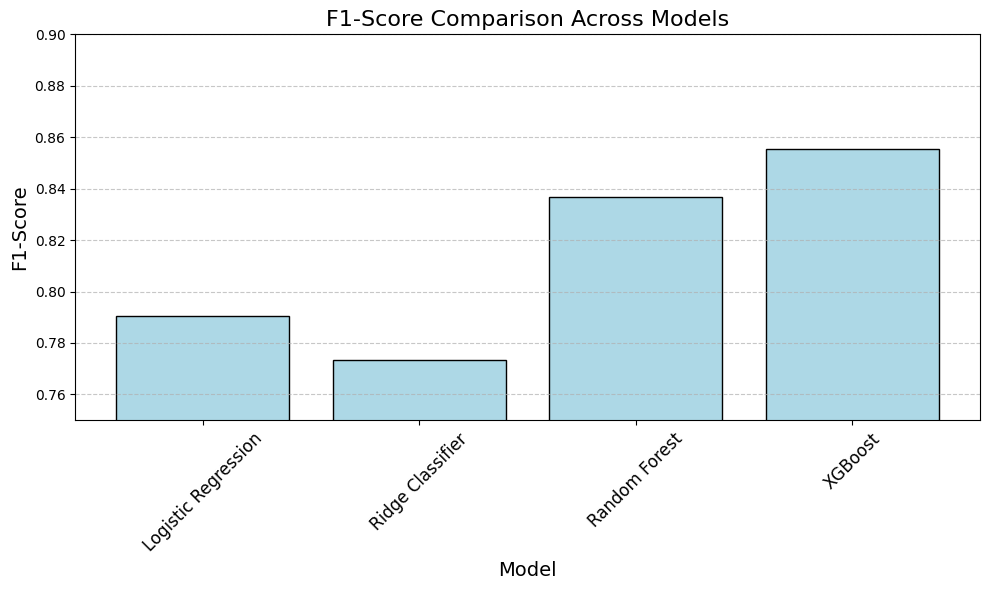

In [31]:
# F1-score data from experiments
experiment_data = {
    "Model": ["Logistic Regression", "Ridge Classifier", "Random Forest", "XGBoost"],
    "F1-Score": [0.7904, 0.7733, 0.8368, 0.8553]
}

# Convert to DataFrame
df_experiments = pd.DataFrame(experiment_data)

# Plot F1-Scores
plt.figure(figsize=(10, 6))
plt.bar(df_experiments["Model"], df_experiments["F1-Score"], color="lightblue", edgecolor="black")
plt.title("F1-Score Comparison Across Models", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.75, 0.9)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


XGBOOST IS THE BEST MODEL

In [32]:
import joblib

# Save the XGBoost model (best performing model)
joblib.dump(pipeline, "final_xgboost_model.pkl")
print("Model saved as final_xgboost_model.pkl")


Model saved as final_xgboost_model.pkl


In [33]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np
import pandas as pd

app = FastAPI()

# Load the model
model = joblib.load("final_xgboost_model.pkl")

class LoanApplication(BaseModel):
    person_age: float
    person_income: float
    person_home_ownership: str
    person_emp_length: float
    loan_intent: str
    loan_amnt: float
    loan_int_rate: float
    loan_percent_income: float
    cb_person_default_on_file: str
    cb_person_cred_hist_length: float

@app.post("/predict")
def predict_loan_approval(application: LoanApplication):
    # Convert input to DataFrame
    input_data = pd.DataFrame([application.dict()])
    
    # Make prediction
    prediction = model.predict(input_data)
    
    return {"loan_approval": bool(prediction[0])}
